In [16]:
#installing libraries and crating connection
from sqlalchemy import create_engine


# Replace with your SQL Server details
server = 'DESKTOP-0C6MJLF\SQLEXPRESS'  # Example: 'localhost' or 'DESKTOP-XYZ\SQLEXPRESS'
database = 'db_Churn'

# Create SQLAlchemy engine for Windows Authentication
engine = create_engine(f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server")

# Test connection
try:
    with engine.connect() as conn:
        print("✅ Connected to SQL Server successfully using Windows Authentication!")
except Exception as e:
    print(f"❌ Connection failed: {e}")


✅ Connected to SQL Server successfully using Windows Authentication!


In [17]:
# Installing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [18]:
query = "SELECT * FROM vw_ChurnData"
data = pd.read_sql(query, engine)
data.head()


,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11098-MAD,Female,30,Yes,Madhya Pradesh,0,31,Deal 1,Yes,No,...,Bank Withdrawal,95.099998,6683.399902,0.00,0,631.719971,7315.120117,Stayed,Others,Others
1,11114-PUN,Male,51,No,Punjab,5,9,Deal 5,Yes,No,...,Bank Withdrawal,49.150002,169.050003,0.00,10,122.370003,301.420013,Churned,Competitor,Competitor had better devices
2,11167-WES,Female,43,Yes,West Bengal,3,28,Deal 1,Yes,Yes,...,Bank Withdrawal,116.050003,8297.500000,42.57,110,1872.979980,10237.910156,Stayed,Others,Others
3,11179-MAH,Male,35,No,Maharashtra,10,12,None,Yes,No,...,Credit Card,84.400002,5969.299805,0.00,0,219.389999,6188.689941,Stayed,Others,Others
4,11180-TAM,Male,75,Yes,Tamil Nadu,12,27,Deal 2,Yes,No,...,Credit Card,72.599998,4084.350098,0.00,140,332.079987,4556.430176,Stayed,Others,Others


**Data Preprocessing**

In [19]:
# Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis =1)

In [20]:
# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


In [21]:
# Manually encode the target variable 'Customer_Status' cos of alphabical order
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})


In [22]:
# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']


In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Train Random Forest Model**

In [24]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

In [25]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Evaluate Model**

In [26]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [27]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[781  66]
 [136 219]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       847
           1       0.77      0.62      0.68       355

    accuracy                           0.83      1202
   macro avg       0.81      0.77      0.78      1202
weighted avg       0.83      0.83      0.83      1202



In [28]:
# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

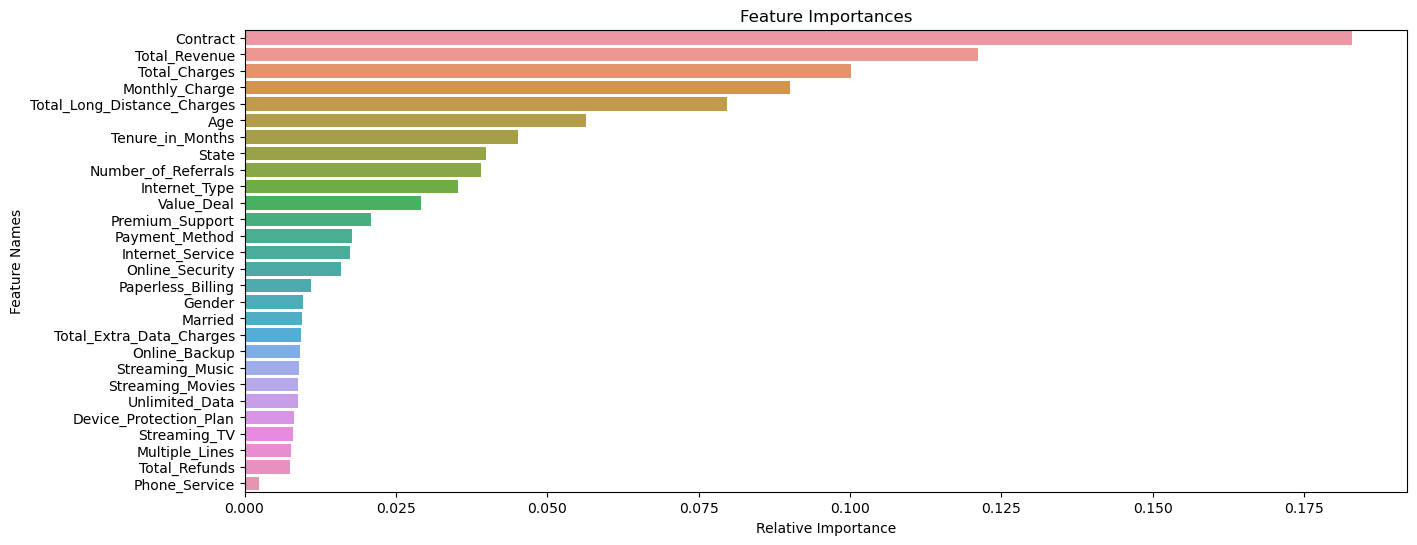

In [29]:
# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

**Use Model for Prediction on New Data**

In [31]:
query = "SELECT * FROM vw_JoinData"
new_data = pd.read_sql(query, engine)
new_data.head()

,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason
0,11751-TAM,Female,18,No,Tamil Nadu,5,7,Deal 5,No,No,...,Mailed Check,24.299999,38.450001,0.0,0,0.000000,38.450001,Joined,Others,Others
1,12056-WES,Male,27,No,West Bengal,2,20,None,Yes,No,...,Bank Withdrawal,90.400002,268.450012,0.0,0,94.440002,362.890015,Joined,Others,Others
2,12136-RAJ,Female,25,Yes,Rajasthan,2,35,None,Yes,No,...,Bank Withdrawal,19.900000,19.900000,0.0,0,11.830000,31.730000,Joined,Others,Others
3,12257-ASS,Female,39,No,Assam,9,1,None,Yes,No,...,Credit Card,19.549999,19.549999,0.0,0,10.200000,29.750000,Joined,Others,Others
4,12340-DEL,Female,51,Yes,Delhi,0,10,None,Yes,No,...,Credit Card,62.799999,62.799999,0.0,0,42.189999,104.989998,Joined,Others,Others


In [32]:
# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

In [33]:
# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']


In [34]:
# Drop columns that won't be used for prediction in the encoded DataFrame
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])


In [35]:
# Make predictions
new_predictions = rf_model.predict(new_data)

In [36]:
# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

In [37]:
# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

In [39]:
# Save the churn predictions DataFrame to SQL Server
original_data.to_sql('prediction_Churn', con=engine, if_exists='replace', index=False)

-1